In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
import seaborn as sns
from sklearn.ensemble  import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import numpy as np

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [97]:
order_df=pd.read_parquet('tezcatli_orders_data.parquet')
dodge_df=pd.read_excel('Housing Starts Analytics.xlsx')
rr_data=pd.read_csv('r&r.csv')

In [98]:
region='Carolinas'
forecast_group='Pr Plk'
order_df['Order Create Date']=pd.to_datetime(order_df['Order Create Date'])
order_df=order_df.loc[order_df['Region Name']!='Export/Interco']
order_df=order_df[order_df['Region Name']==region]
order_df.loc[order_df['forecast_group']==forecast_group]
# order_df=order_df.loc[order_df['Product Segment'].isin(['Exterior','Interior'])]
order_df=order_df[[ 'Order Create Date',
       'Region Name', 'District Name', 'forecast_group', 'Order Volume (STD)']]

order_df['year'] = order_df['Order Create Date'].dt.year
order_df['month'] = order_df['Order Create Date'].dt.month
order_df=order_df.sort_values(by='Order Create Date').reset_index(drop=True)
def convert_to_year_quarter(year,month):
    year = year
    quarter = (month - 1) // 3 + 1
    return f'{year}Q{quarter}'
order_df['Calendar Year']=order_df.apply(lambda x:convert_to_year_quarter(x['year'],x['month']),axis=1)

order_df_filter=order_df


In [101]:
order_df_filter=order_df_filter.groupby(['Order Create Date','Region Name','District Name'])['Order Volume (STD)'].sum().reset_index()
order_df_filter

,Order Create Date,Region Name,District Name,Order Volume (STD)
0,2013-04-01,Carolinas,East Carolinas,45540.00
1,2013-04-01,Carolinas,West Carolinas,57088.50
2,2013-04-02,Carolinas,East Carolinas,16725.00
3,2013-04-02,Carolinas,Virginia,9444.50
4,2013-04-02,Carolinas,West Carolinas,26529.75
...,...,...,...,...
7431,2023-07-28,Carolinas,West Carolinas,155851.50
7432,2023-07-30,Carolinas,West Carolinas,18975.00
7433,2023-07-31,Carolinas,East Carolinas,94452.00
7434,2023-07-31,Carolinas,Virginia,13282.50


In [112]:
order_df_filter['year'] = order_df_filter['Order Create Date'].dt.year
order_df_filter['month'] = order_df_filter['Order Create Date'].dt.month
order_df_filter = order_df_filter.groupby(['year', 'month'])['Order Volume (STD)'].sum().reset_index()
order_df_filter['Order Create Date']=order_df_filter['year'].astype('string')+'-'+order_df_filter['month'].astype('string')+'-01'
order_df_filter['Order Create Date']=pd.to_datetime(order_df_filter['Order Create Date'])

In [101]:
# dodge_df_sf=dodge_df.loc[dodge_df['Housing Type']=='Detached']
# dodge_df_mf=dodge_df.loc[dodge_df['Housing Type']=='Low']

In [103]:
# dodge_df_sf['Calendar - Quarter'].replace({'Q1':'Q2','Q2':'Q3','Q3':'Q4','Q4':'Q1'},inplace=True)
# dodge_df['Calendar - Quarter'].replace({'Q1':'Q7','Q7':'Q9'})

In [4]:
# dodge_df_sf.loc[dodge_df_sf['Calendar - Quarter']=='Q1',['Calendar - Year']]=dodge_df_sf.loc[dodge_df_sf['Calendar - Quarter']=='Q1','Calendar - Year']+1

In [5]:
# dodge_df_sf.reset_index(drop=True,inplace=True)

In [102]:
dodge_df=dodge_df.loc[dodge_df['Housing Type']!='High']
dodge_df['Calendar Year']=dodge_df['Calendar - Year'].astype('str')+dodge_df['Calendar - Quarter'].astype('str')
dodge_df=dodge_df.drop(['Calendar - Year','Calendar - Quarter'],axis=1)
dodge_df=dodge_df.groupby(['Calendar Year','Region Name'])['Units'].sum().reset_index()

In [105]:
dodge_df['Order Create Date']=pd.to_datetime(dodge_df['Calendar Year'])

In [117]:
dodge_df=dodge_df[dodge_df['Region Name']==region]

In [118]:
merge_df=order_df_filter.merge(dodge_df,on=['Order Create Date'],how='left')
# merge_df['Calendar Year']=pd.to_datetime(merge_df['Calendar Year'])


In [120]:
merge_df.fillna(method='ffill',inplace=True)

In [122]:
merge_df['Units']=merge_df['Units']/3

In [123]:
rr_data
rr_data=rr_data.drop(['District','District Number','Sub Division','Division'],axis=1)

In [127]:
rr_data['Order Create Date']=pd.to_datetime(rr_data['Calendar Year'])

In [131]:
rr_data=rr_data[rr_data['Region Name']==region]

In [137]:
rr_data

,Region Name,District Name,Calendar Year,Project Count,Order Create Date
1564,Carolinas,East Carolinas,2004Q1,27850,2004-01-01
1565,Carolinas,East Carolinas,2004Q2,28217,2004-04-01
1566,Carolinas,East Carolinas,2004Q3,28638,2004-07-01
1567,Carolinas,East Carolinas,2004Q4,29120,2004-10-01
1568,Carolinas,East Carolinas,2005Q1,29652,2005-01-01
...,...,...,...,...,...
1835,Carolinas,West Carolinas,2025Q4,74780,2025-10-01
1836,Carolinas,West Carolinas,2026Q1,76181,2026-01-01
1837,Carolinas,West Carolinas,2026Q2,76299,2026-04-01
1838,Carolinas,West Carolinas,2026Q3,76166,2026-07-01


In [140]:
rr_data=rr_data.groupby('Order Create Date')['Project Count'].sum().reset_index()

In [142]:
merge_df=merge_df.merge(rr_data,on=['Order Create Date'],how='left')

In [144]:
merge_df.fillna(method='ffill',inplace=True)
merge_df['Project Count']=merge_df['Project Count']/3

In [147]:
df=merge_df.loc[merge_df['Region Name']==region]

In [152]:
df=df[['Order Create Date','Units','Project Count','Order Volume (STD)']]

In [12]:
# df['Calendar Year']=pd.to_datetime(df['Calendar Year'])
# df.reset_index(drop=True,inplace=True)

In [13]:
# df=df.groupby(by=['Calendar Year'])['Project Count','Units','Order Volume (STD)'].sum().reset_index()

In [14]:
# df=df.set_index('Calendar Year')

In [33]:
# df['Order Create Date']=df.index

In [154]:
df

,Order Create Date,Units,Project Count,Order Volume (STD)
0,2013-04-01,7069.000000,32812.000000,2515675.75
1,2013-05-01,7069.000000,32812.000000,2458630.50
2,2013-06-01,7069.000000,32812.000000,2296812.00
3,2013-07-01,6568.666667,33185.666667,2273197.25
4,2013-08-01,6568.666667,33185.666667,2325700.71
...,...,...,...,...
119,2023-03-01,9599.409327,58701.000000,8232933.50
120,2023-04-01,10389.214304,58076.000000,6180111.00
121,2023-05-01,10389.214304,58076.000000,5743970.00
122,2023-06-01,10389.214304,58076.000000,6820291.50


In [153]:
df=df.sort_values(by='Order Create Date')

In [60]:
# df_date=pd.date_range(start=df['Order Create Date'].astype('str').iloc[0],end=df['Order Create Date'].astype('str').iloc[-1],freq='MS')
# df_date=pd.DataFrame(df_date,columns=['Order Create Date'])

In [64]:
# df=df_date.merge(df,on='Order Create Date',how='left')

In [68]:
# df.fillna(method='ffill',inplace=True)

In [74]:
# df[['Project Count','Units','Order Volume (STD)']]=df[['Project Count','Units','Order Volume (STD)']]/3

In [157]:
df=df.set_index('Order Create Date')

In [158]:
seq_size=5
x=[]
y=[]

for i in range(len(df) - seq_size - 1):
    # Extract the current window (input sequence) from the DataFrame
    w=df.iloc[i:(i + seq_size), :]
    x.append(list(np.array(w).ravel()))
    w=df.iloc[(i + seq_size), :]
    y.append(list(np.array(w).ravel()))
    
    

In [159]:
def to_sequences(df, seq_size=1):

    x = []  # List to store the input sequences (windows)
    y = []  # List to store the output values (targets)

    for i in range(len(df) - seq_size - 1):
        # Extract the current window (input sequence) from the DataFrame
        window = df[i:(i + seq_size), 0]
        x.append(list(np.array(window).ravel()))

        # Get the target value corresponding to the next time step after the input sequence
        y.append(df[i + seq_size, 0])

    # Convert the lists to numpy arrays for further processing
    return np.array(x), np.array(y)


In [160]:
model=RandomForestRegressor(n_estimators=30)

In [161]:
x=np.array(x)
y=np.array(y)

In [162]:
x=x[:-6,:]
y=y[:-6,:] 
x_test=x[-6:,:]
y_test=y[-6:,:]

In [163]:
model.fit(x,y)

RandomForestRegressor(n_estimators=30)

In [164]:

y_p=model.predict(x_test)

In [165]:
mean_absolute_error(y_test[:,2],y_p[:,2])

312909.5388888891

In [66]:
mean_absolute_error(y_test[:,2],y_p[:,2])

767177.4888888892

In [67]:
mean_absolute_percentage_error(y_test[:,2],y_p[:,2])

0.04681774322511937

In [166]:
mean_absolute_percentage_error(y_test[:,2],y_p[:,2])

0.06017531140240582

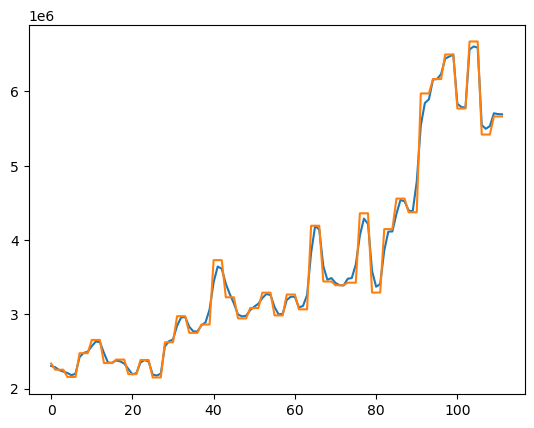

In [92]:
plt.plot(y_p[:,2])
plt.plot(y[:,2])

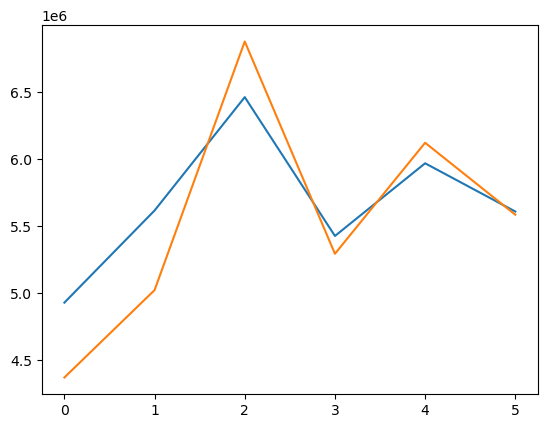

In [168]:
plt.plot(y_p[:,2])
plt.plot(y_test[:,2])

In [169]:

y_p=model.predict(x)

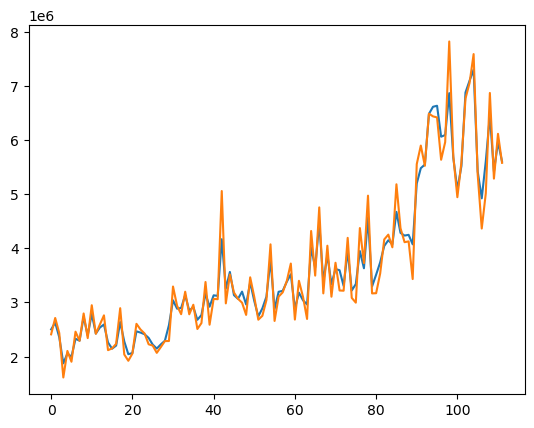

In [170]:
plt.plot(y_p[:,2])
plt.plot(y[:,2])